In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import pickle
import warnings
import tensorflow as tf
from pathlib import Path
from collections import defaultdict, Counter
from tqdm import tqdm
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import xgboost as XGBoostClassifier

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# NLP and text processing libraries
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet as wn
try:
    from textblob import TextBlob
    textblob_available = True
except ImportError:
    textblob_available = False
    print("TextBlob not available. Some features will be disabled.")

# Feature extraction and model evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Deep learning libraries
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import TextVectorization

# Try to import transformers
try:
    import transformers
    from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
    from transformers import TFBertForSequenceClassification, BertTokenizer
    transformers_available = True
except ImportError:
    transformers_available = False
    print("Transformers library not available. Install with: pip install transformers")

# NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('taggers/averaged_perceptron_tagger')
except LookupError:
    nltk.download('punkt')
    nltk.download('punkt_tab')
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('averaged_perceptron_tagger_eng')
    
# Add custom path for NLTK data if needed
nltk.data.path.append('C:/Users/birim/nltk_data')

# Check scikit-learn version
import sklearn
print(f"Using scikit-learn version: {sklearn.__version__}")
print("This model will be saved with this version of scikit-learn.")

# Initialize encoder
Encoder = LabelEncoder()

Transformers library not available. Install with: pip install transformers
Using scikit-learn version: 1.5.1
This model will be saved with this version of scikit-learn.


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\birim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\birim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\birim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\birim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\birim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\birim\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_pe

In [12]:
# get data csv to dataframe
post_users_original = pd.read_csv('../datasets/selfharm_dataset.csv')

# copy dataframe for analyze
post_users_analyze = post_users_original.copy()

# get list of labels
list_labels = post_users_analyze['Label'].unique()

post_users_original.head()

,User,Post,Label
0,user-0,"['Its not a viable option, and youll be leavin...",Supportive
1,user-1,['It can be hard to appreciate the notion that...,Ideation
2,user-2,"['Hi, so last night i was sitting on the ledge...",Behavior
3,user-3,['I tried to kill my self once and failed badl...,Attempt
4,user-4,['Hi NEM3030. What sorts of things do you enjo...,Ideation


In [13]:
# visualization random post 
post_users_original['Post'][0]

"['Its not a viable option, and youll be leaving your wife behind. Youd Pain her beyond comprehension.It sucks worrying about money, I know that first hand. It can definitely feel hopeless, as you seem to be Tired aware of. Your wife might need to chip in financially. I know time is an issue, but even 10-15 hours a Asthenia could alleviate a lot of the pressure. In the meantime, get your shit together - write that resume tomorrow. No excuses, get it done and send it out. Whether you believe in some sort of powerful being or force governing things or not, things really do work themselves out. This is a big test for you, and youll pull through. Just try to stay as positive as you can and everything will work out.']"

Label
Ideation      171
Supportive    108
Indicator      99
Behavior       77
Attempt        45
Name: count, dtype: int64

<Axes: xlabel='Label', ylabel='count'>

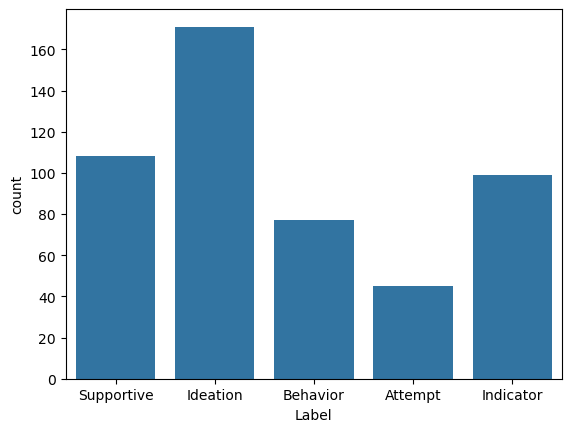

In [14]:
# show counts label in dataframe
display(post_users_original['Label'].value_counts())

# show chart distribuition of Labels
display(sns.countplot(data=post_users_original, x="Label"))

In [15]:
# more information about data 
post_users_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    500 non-null    object
 1   Post    500 non-null    object
 2   Label   500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


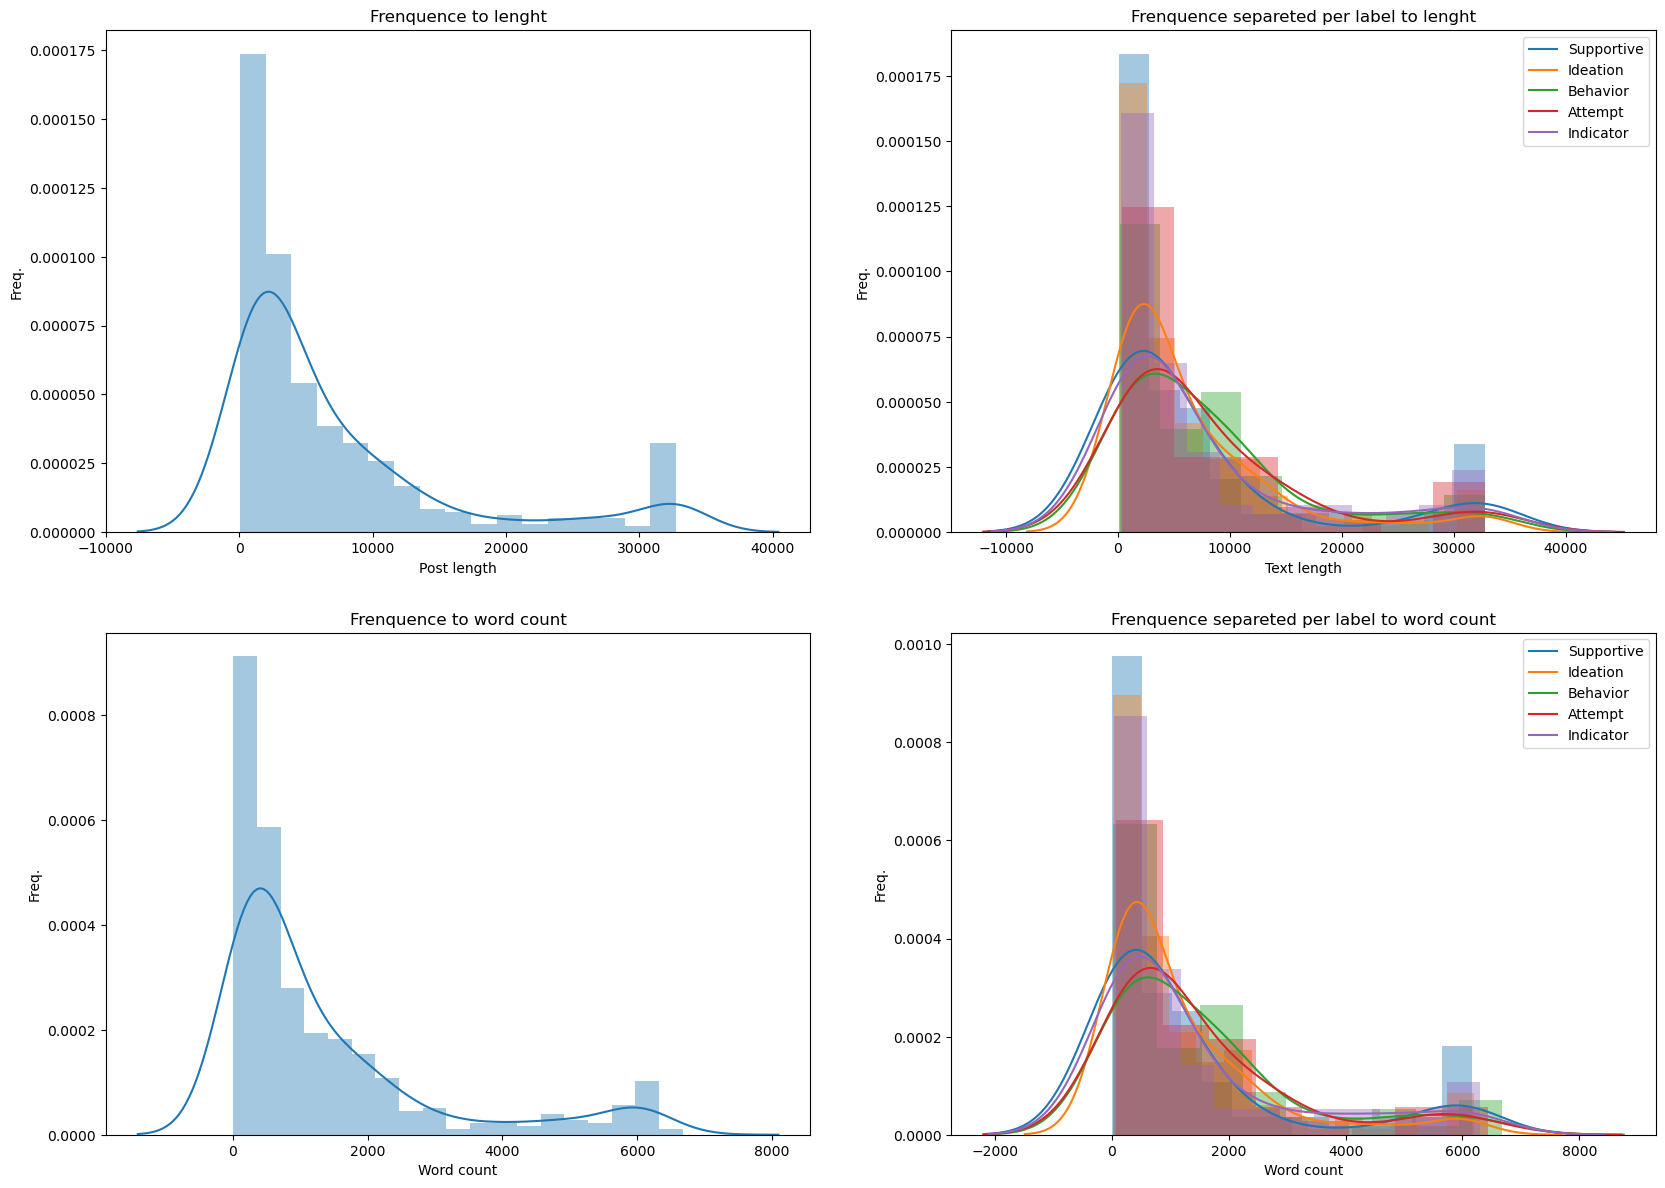

In [16]:
# show frenquence to lenght for each post
post_users_analyze['Post_len'] = post_users_analyze['Post'].str.len()
plt.figure(figsize=(20,30))
plt.subplot(4, 2, 1)
ax = sns.distplot(post_users_analyze['Post_len'])
ax.set(xlabel='Post length', ylabel='Freq.')
plt.title('Frenquence to lenght')

# show frenquence separeted per label to lenght for each post
plt.subplot(4, 2, 2)
i = 0
while i < len(list_labels):
    ax = sns.distplot(post_users_analyze[post_users_analyze['Label'] == list_labels[i]]['Post_len'])
    i = i + 1
ax.set(xlabel='Text length', ylabel='Freq.')
ax.legend(labels=list_labels)
plt.title('Frenquence separeted per label to lenght')

# show frenquence to word count for each post
post_users_analyze['word_count'] = post_users_analyze['Post'].str.split().map(lambda x:len(x))
plt.subplot(4, 2, 3)
ax = sns.distplot(post_users_analyze['word_count'])
ax.set(xlabel='Word count', ylabel='Freq.')
plt.title('Frenquence to word count')

# show frenquence separeted per label to word count for each post
plt.subplot(4, 2, 4)
i = 0
while i < len(list_labels):
    ax = sns.distplot(post_users_analyze[post_users_analyze['Label'] == list_labels[i]]['word_count'])
    i = i + 1
ax.set(xlabel='Word count', ylabel='Freq.')
ax.legend(labels=list_labels)
plt.title('Frenquence separeted per label to word count')
plt.show()

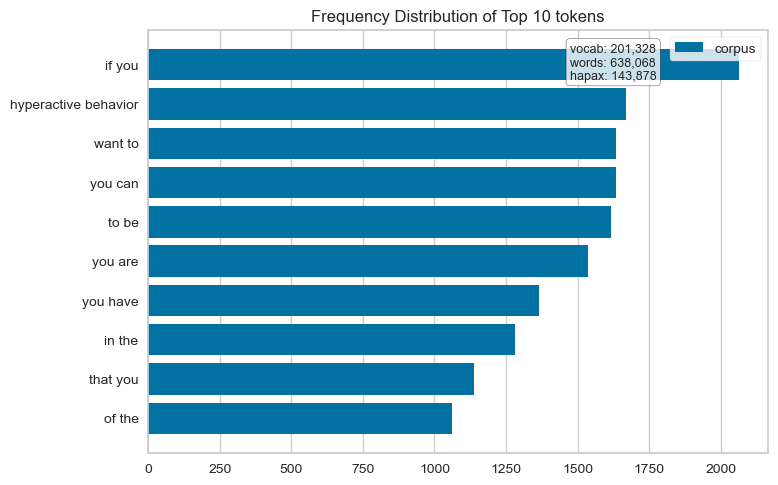

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer  # ✅ This line is essential

# Extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
docs = vectorizer.fit_transform(post_users_analyze['Post'].tolist())

# Get bigram feature names
features = vectorizer.get_feature_names_out()

# Visualize top 10 bigrams
visualizer = FreqDistVisualizer(features=features, orient='h', n=10)
visualizer.fit(docs)
visualizer.show()


In [18]:
# drop column user (not used)
post_users_analyze = post_users_analyze.drop(columns=['User'])

# drop null values in post
post_users_analyze['Post'].dropna(inplace=True)

# set lower case for post
post_users_analyze['Post'] = [entry.lower() for entry in post_users_analyze['Post']]

# transform text into token
post_users_analyze['Post'] = [word_tokenize(entry) for entry in post_users_analyze['Post']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index, entry in enumerate(post_users_analyze['Post']):
    final_words = []
    word_lemmatized = WordNetLemmatizer()
    
    # pos_tag functon below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else
    for word, tag in pos_tag(entry):
        
        # below condition is to check for stop words and consider only aphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_final = word_lemmatized.lemmatize(word, tag_map[tag[0]])
            final_words.append(word_final)
            
    post_users_analyze.loc[index,'post_new'] = str(final_words)

    
# set news values for column Post and drop column aux    
post_users_analyze['Post'] = post_users_analyze['post_new'].str.replace("'", "")
post_users_analyze['Post'] = post_users_analyze['Post'].str.replace(",", "")
post_users_analyze['Post'] = post_users_analyze['Post'].str.replace("[", "")
post_users_analyze['Post'] = post_users_analyze['Post'].str.replace("]", "")
post_users_analyze = post_users_analyze.drop(columns=['post_new'])

# show values pre-processed
post_users_analyze.head()

,Post,Label,Post_len,word_count
0,viable option youll leave wife behind youd pai...,Supportive,721,133
1,hard appreciate notion could meet someone else...,Ideation,11497,2132
2,last night sit ledge window contemplate whethe...,Behavior,2460,470
3,try kill self fail badly cause moment want rea...,Attempt,4629,888
4,sort thing enjoy always welcome music suggesti...,Ideation,1114,205


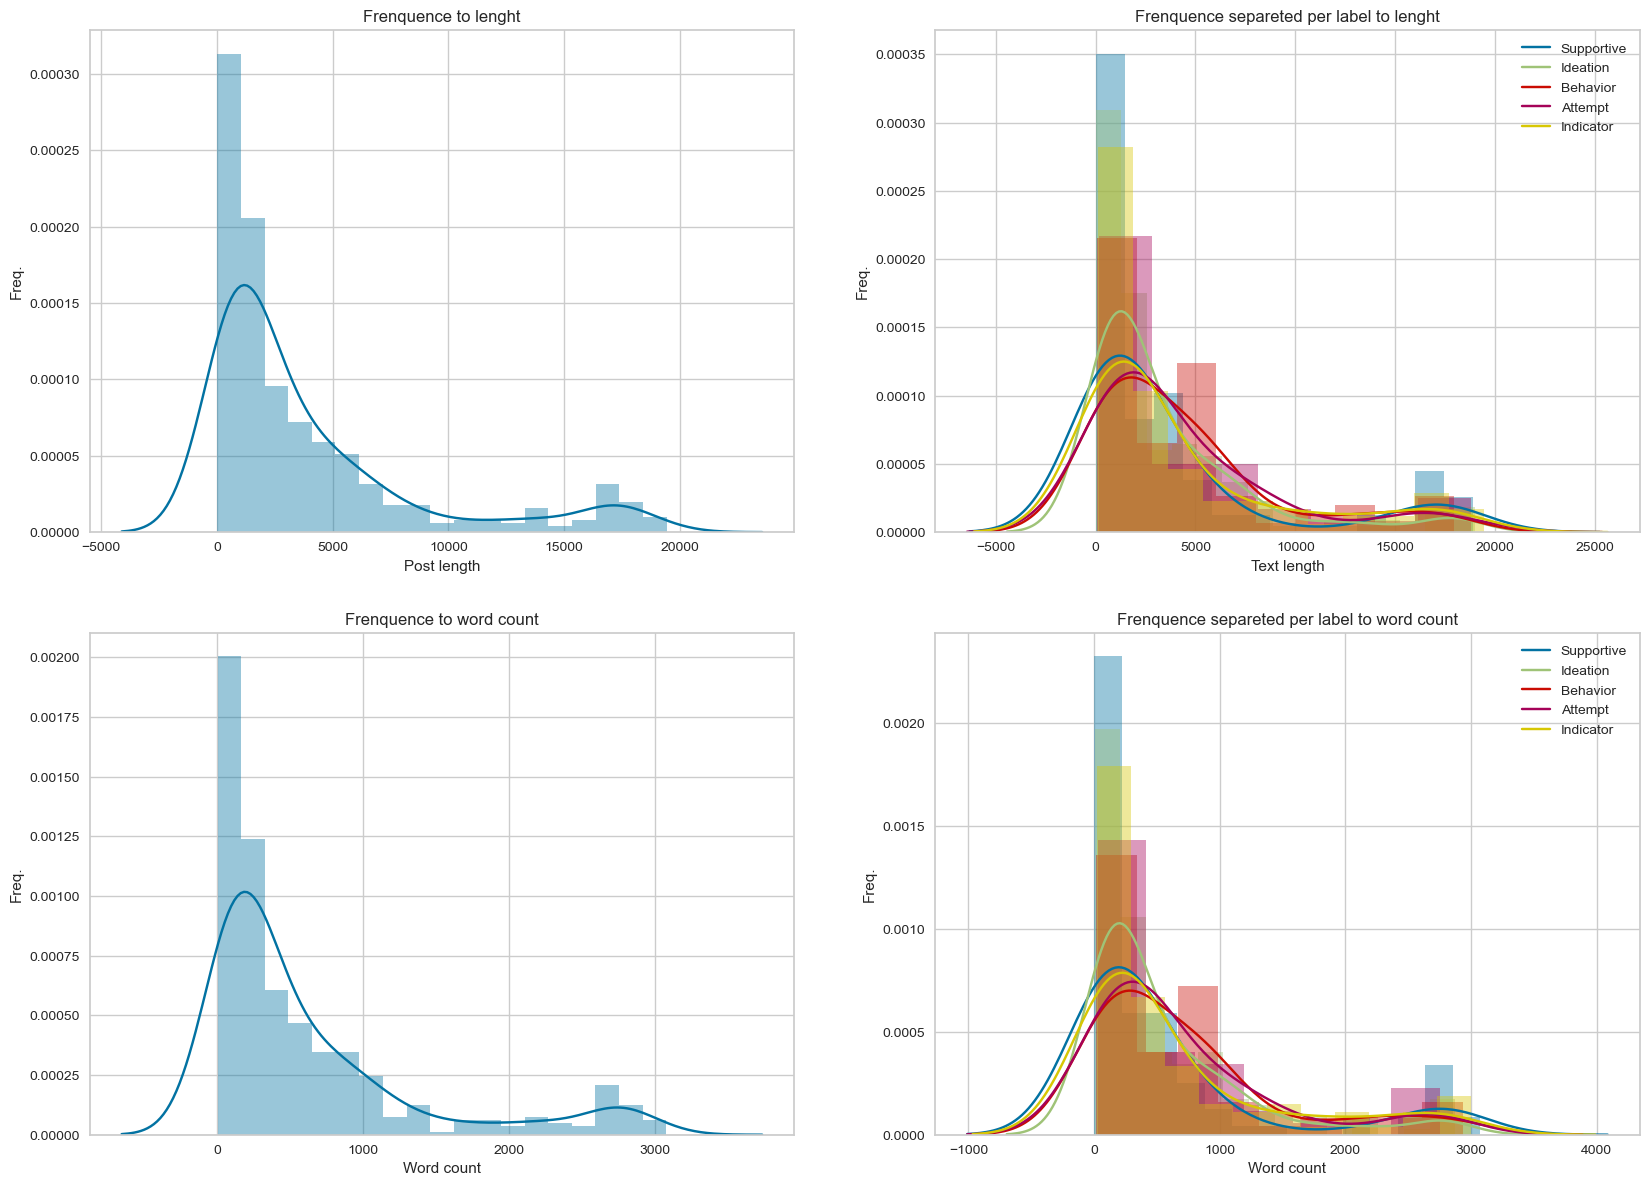

In [19]:
# new show frenquence to lenght for each post
post_users_analyze['Post_len'] = post_users_analyze['Post'].str.len()
plt.figure(figsize=(20,30))
plt.subplot(4, 2, 1)
ax = sns.distplot(post_users_analyze['Post_len'])
ax.set(xlabel='Post length', ylabel='Freq.')
plt.title('Frenquence to lenght')

# new show frenquence separeted per label to lenght for each post
plt.subplot(4, 2, 2)
i = 0
while i < len(list_labels):
    ax = sns.distplot(post_users_analyze[post_users_analyze['Label'] == list_labels[i]]['Post_len'])
    i = i + 1
ax.set(xlabel='Text length', ylabel='Freq.')
ax.legend(labels=list_labels)
plt.title('Frenquence separeted per label to lenght')

# new show frenquence to word count for each post
post_users_analyze['word_count'] = post_users_analyze['Post'].str.split().map(lambda x:len(x))
plt.subplot(4, 2, 3)
ax = sns.distplot(post_users_analyze['word_count'])
ax.set(xlabel='Word count', ylabel='Freq.')
plt.title('Frenquence to word count')

# new show frenquence separeted per label to word count for each post
plt.subplot(4, 2, 4)
i = 0
while i < len(list_labels):
    ax = sns.distplot(post_users_analyze[post_users_analyze['Label'] == list_labels[i]]['word_count'])
    i = i + 1
ax.set(xlabel='Word count', ylabel='Freq.')
ax.legend(labels=list_labels)
plt.title('Frenquence separeted per label to word count')
plt.show()

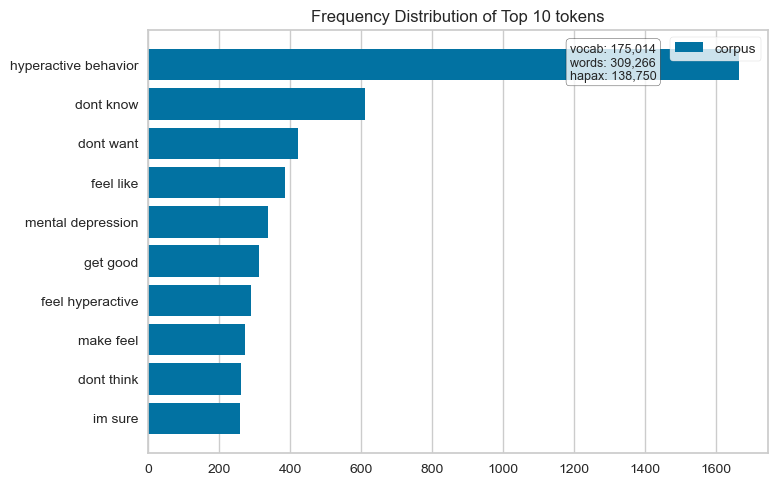

<Axes: title={'center': 'Frequency Distribution of Top 10 tokens'}>

In [20]:
# show again a 10 most bigrams frenquece (cleaned data)
vectorizer = CountVectorizer(ngram_range=(2, 2))
docs = vectorizer.fit_transform(post_users_analyze['Post'].tolist())
features = vectorizer.get_feature_names_out()

visualizer = FreqDistVisualizer(features=features, orient='h', n=10)
visualizer.fit(docs)
visualizer.show()

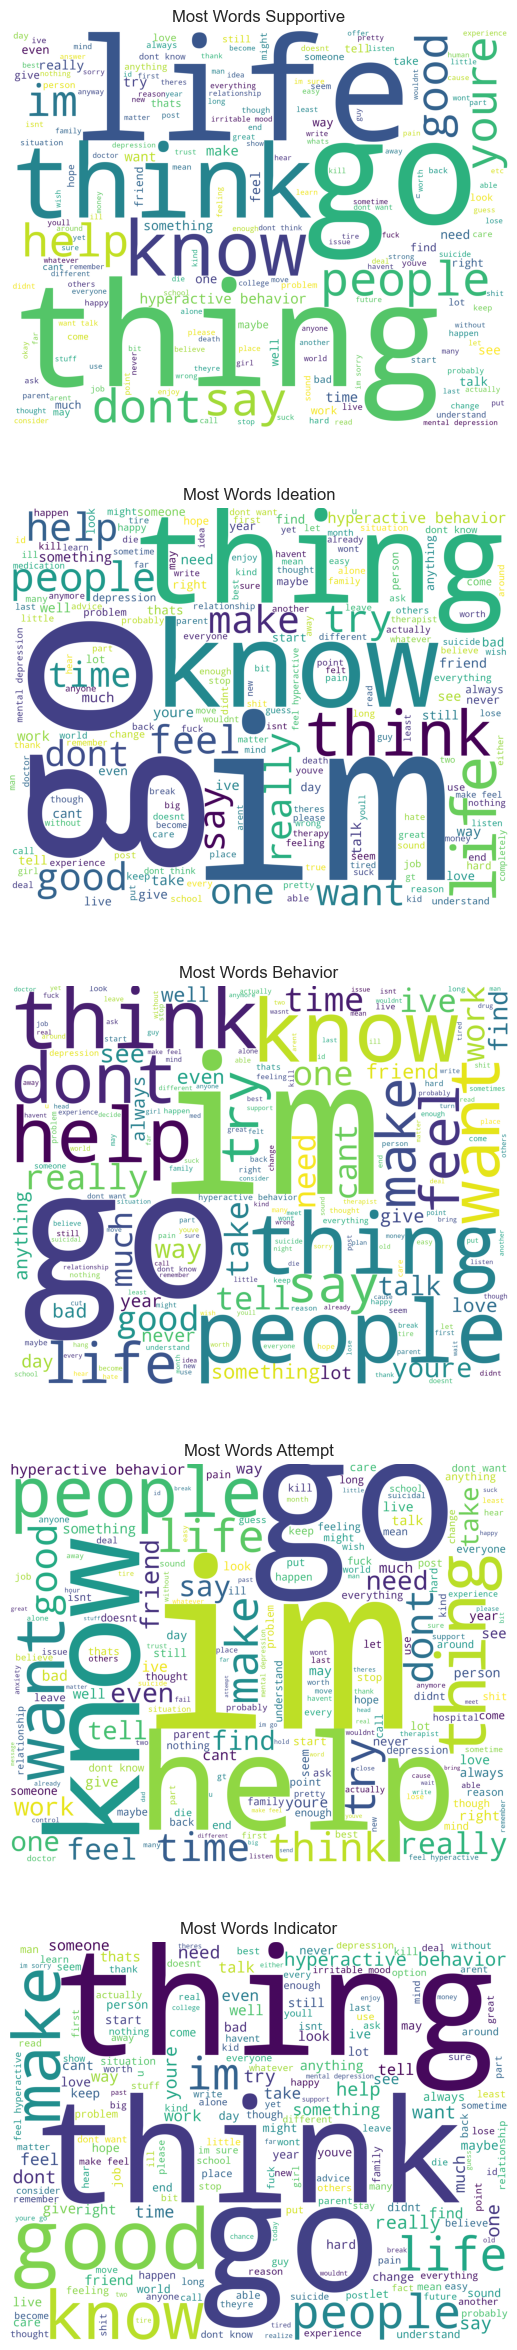

In [22]:
# Ensure the required library is installed
%pip install wordcloud

# Import WordCloud and STOPWORDS
from wordcloud import WordCloud, STOPWORDS

# words cloud of post 
fig, axes = plt.subplots(5, 1, figsize=[50, 30])

i = 0
while i < len(list_labels):
    df_aux = post_users_analyze[post_users_analyze['Label'] == list_labels[i]]['Post']

    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=2500,
                          height=2000
                          ).generate(" ".join(df_aux))

    axes[i].imshow(wordcloud)
    axes[i].axis('off')
    axes[i].set_title(f'Most Words {str(list_labels[i])}')
    i = i + 1

plt.show()   

In [24]:
# ====================================
# Data Loading and Preprocessing
# ====================================

def load_data(file_path):
    """Load the dataset and perform initial preprocessing."""
    print(f"Loading and preprocessing data from {file_path}")
    data = pd.read_csv(file_path)
    
    # Display basic information
    print(f"Data loaded. Shape: {data.shape}")
    
    # Display class distribution
    print("\nClass distribution:")
    for cls, count in data.iloc[:, -1].value_counts().items():
        percentage = count / len(data) * 100
        print(f"{cls}: {count} samples ({percentage:.2f}%)")
    
    return data

def preprocess_text(text, advanced=True):
    """Advanced text preprocessing function."""
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase and remove URLs, special characters
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    
    # Keep some meaningful punctuation that might be relevant for sentiment/emotion
    if advanced:
        # Replace emoticons with text representations
        text = re.sub(r':\)', ' happy ', text)
        text = re.sub(r':\(', ' sad ', text)
        text = re.sub(r':\/', ' skeptical ', text)
        
        # Replace multiple punctuation with single + space
        text = re.sub(r'\.{2,}', ' ellipsis ', text)
        text = re.sub(r'\!{2,}', ' exclamation ', text)
        text = re.sub(r'\?{2,}', ' question ', text)
        
        # Replace common mental health abbreviations/slang
        text = re.sub(r'\bsh\b', 'selfharm', text)
        text = re.sub(r'\bkms\b', 'kill myself', text)
        text = re.sub(r'\bkys\b', 'kill yourself', text)
        text = re.sub(r'\bsiucide\b', 'suicide', text)  # Common misspelling
    
    # Remove remaining special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Keep negation words as they are important for sentiment
    negation_words = {'no', 'not', 'none', 'never', 'nothing'}
    stop_words = stop_words - negation_words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    
    # Lemmatize with POS tagging
    def get_wordnet_pos(tag):
        tag_dict = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
        return tag_dict.get(tag[0].upper(), wn.NOUN)
    
    lemmatizer = WordNetLemmatizer()
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_tokens]
    
    return " ".join(lemmatized)

def extract_advanced_features(texts):
    """Extract advanced NLP features beyond bag of words."""
    features = pd.DataFrame()
    
    # Text length features
    features['text_length'] = [len(text) for text in texts]
    features['word_count'] = [len(text.split()) for text in texts]
    
    # Custom sentiment analysis using lexicon-based approach
    # This replaces TextBlob's sentiment analysis
    positive_words = {'good', 'great', 'happy', 'positive', 'excellent', 'better', 'hope',
                     'improve', 'well', 'supportive', 'support', 'help', 'best', 'love',
                     'wonderful', 'glad', 'better', 'awesome', 'amazing', 'appreciate'}
    
    negative_words = {'bad', 'sad', 'negative', 'terrible', 'awful', 'worse', 'horrible',
                     'hate', 'depression', 'depressed', 'anxiety', 'anxious', 'fear', 'scared',
                     'hurt', 'pain', 'suffer', 'miserable', 'hopeless', 'die', 'death', 'kill',
                     'suicide', 'suicidal', 'cut', 'harm', 'worthless', 'alone', 'lonely'}
    
    # Calculate sentiment scores
    polarities = []
    for text in tqdm(texts, desc="Extracting sentiment"):
        words = set(text.lower().split())
        pos_score = len(words.intersection(positive_words))
        neg_score = len(words.intersection(negative_words))
        
        # Calculate polarity (-1 to 1)
        if pos_score + neg_score > 0:
            polarity = (pos_score - neg_score) / (pos_score + neg_score)
        else:
            polarity = 0
            
        polarities.append(polarity)
    
    features['sentiment_polarity'] = polarities
    
    # Count specific keywords related to mental health
    suicide_keywords = ['suicide', 'kill', 'die', 'death', 'dead', 'end']
    harm_keywords = ['cut', 'harm', 'hurt', 'pain', 'blade', 'blood', 'scar']
    emotion_keywords = ['sad', 'depress', 'hate', 'lonely', 'alone', 'miserable', 'empty']
    help_keywords = ['help', 'support', 'therapy', 'therapist', 'counseling', 'treatment']
    
    features['suicide_keyword_count'] = [sum(1 for word in text.split() if word in suicide_keywords) for text in texts]
    features['harm_keyword_count'] = [sum(1 for word in text.split() if word in harm_keywords) for text in texts]
    features['emotion_keyword_count'] = [sum(1 for word in text.split() if word in emotion_keywords) for text in texts]
    features['help_keyword_count'] = [sum(1 for word in text.split() if word in help_keywords) for text in texts]
    
    # First-person pronoun usage (indicator of self-reference)
    first_person = ['i', 'me', 'my', 'mine', 'myself']
    features['first_person_count'] = [sum(1 for word in text.split() if word in first_person) for text in texts]
    
    # Count question marks (could indicate seeking help)
    features['question_count'] = [text.count('?') for text in texts]
    
    # Negation words (important for sentiment and intention)
    negation_words = ['no', 'not', 'never', 'none', 'nothing', 'nowhere', 'nobody']
    features['negation_count'] = [sum(1 for word in text.split() if word in negation_words) for text in texts]
    
    return features

def create_augmented_data(X, y, minor_classes, multiplier=2):
    """Create augmented data for minority classes using synonym replacement and other techniques."""
    texts = list(X)
    labels = list(y)
    
    # For each minority class
    for cls in minor_classes:
        # Get indices of samples in this class
        indices = [i for i, label in enumerate(y) if label == cls]
        class_texts = [X[i] for i in indices]
        
        # Determine how many new samples to create
        n_new = len(indices) * (multiplier - 1)
        
        # Create augmented samples
        for _ in range(n_new):
            # Randomly select a sample to augment
            idx = np.random.choice(len(class_texts))
            text = class_texts[idx]
            
            # Apply random augmentation techniques
            aug_type = np.random.choice(['synonym', 'insert', 'swap', 'delete'])
            
            if aug_type == 'synonym':
                # Simple synonym replacement (in practice, use a more sophisticated approach)
                words = text.split()
                if len(words) > 3:  # Only if we have enough words
                    replace_idx = np.random.randint(0, len(words))
                    # Here, using a dummy synonym approach - in practice use WordNet or similar
                    synonyms = {'sad': ['depressed', 'unhappy', 'miserable'],
                              'happy': ['glad', 'joyful', 'pleased'],
                              'angry': ['mad', 'furious', 'irritated'],
                              'want': ['desire', 'wish', 'need'],
                              'think': ['believe', 'consider', 'reckon']}
                    
                    word = words[replace_idx]
                    if word in synonyms:
                        words[replace_idx] = np.random.choice(synonyms[word])
                        
                    augmented_text = ' '.join(words)
                else:
                    augmented_text = text
                    
            elif aug_type == 'insert':
                # Random word insertion
                words = text.split()
                if len(words) > 0:
                    insert_idx = np.random.randint(0, len(words) + 1)
                    insert_words = ['really', 'very', 'quite', 'extremely', 'somewhat']
                    words.insert(insert_idx, np.random.choice(insert_words))
                    augmented_text = ' '.join(words)
                else:
                    augmented_text = text
                    
            elif aug_type == 'swap':
                # Random word swap
                words = text.split()
                if len(words) > 3:
                    idx1, idx2 = np.random.choice(len(words), 2, replace=False)
                    words[idx1], words[idx2] = words[idx2], words[idx1]
                    augmented_text = ' '.join(words)
                else:
                    augmented_text = text
                    
            else:  # delete
                # Random word deletion
                words = text.split()
                if len(words) > 3:
                    delete_idx = np.random.randint(0, len(words))
                    words.pop(delete_idx)
                    augmented_text = ' '.join(words)
                else:
                    augmented_text = text
            
            # Add the augmented sample
            texts.append(augmented_text)
            labels.append(cls)
    
    return np.array(texts), np.array(labels)

def advanced_data_augmentation(X, y, target_samples=None):
    """Perform advanced data augmentation with multiple techniques."""
    print("\nPerforming advanced data augmentation...")
    
    # Get class distribution
    class_counts = Counter(y)
    print("Original class distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} samples")
    
    # Determine target count per class
    if target_samples is None:
        majority_count = max(class_counts.values())
        target_samples = majority_count
    
    # Identify minority classes
    minority_classes = [cls for cls, count in class_counts.items() if count < target_samples]
    
    # Augment data for minority classes
    X_aug, y_aug = create_augmented_data(X, y, minority_classes)
    
    # Apply SMOTE for further balancing
    try:
        # Convert to TF-IDF for SMOTE (SMOTE requires numeric features)
        print("Applying SMOTE to further balance classes...")
        vectorizer = TfidfVectorizer(max_features=5000)
        X_vec = vectorizer.fit_transform(X_aug)
        
        # Apply SMOTE
        smote = SMOTE(random_state=42)
        X_vec_smote, y_smote = smote.fit_resample(X_vec, y_aug)
        
        # Get indices of resampled data
        unique_indices = []
        for i, y_val in enumerate(y_aug):
            if y_val in y_smote:
                # Find first matching index in y_smote and remove it
                idx = np.where(y_smote == y_val)[0][0]
                unique_indices.append(i)
                y_smote = np.delete(y_smote, idx)
                
        # Get original text for non-synthetic samples
        X_resampled = [X_aug[i] for i in unique_indices]
        y_resampled = [y_aug[i] for i in unique_indices]
        
        # Generate text for synthetic samples using inverse transform
        if len(y_smote) > 0:
            # In a real implementation, you'd need a more sophisticated approach
            # to convert SMOTE-generated TF-IDF vectors back to text
            # This is a placeholder that would need to be replaced
            print("Note: Using placeholder for synthetic sample text generation")
            
            # Convert remaining synthetic samples to text (this is just a placeholder)
            # In practice, you would need a more sophisticated approach or use a text-specific augmentation method
            for y_val in y_smote:
                # Generate a placeholder text for this class
                synthetic_text = f"Synthetic sample for class {y_val}"
                X_resampled.append(synthetic_text)
                y_resampled.append(y_val)
        
        X_aug = np.array(X_resampled)
        y_aug = np.array(y_resampled)
    
    except Exception as e:
        print(f"Error applying SMOTE: {e}")
        print("Continuing with basic augmentation only.")
    
    # Report augmented class distribution
    new_class_counts = Counter(y_aug)
    print("Augmented class distribution:")
    for cls, count in new_class_counts.items():
        print(f"{cls}: {count} samples")
    
    return X_aug, y_aug

# ====================================
# Model Building Functions
# ====================================

def build_tfidf_rf_pipeline(max_features=10000, ngram_range=(1, 3), n_estimators=500):
    """Build an enhanced TF-IDF + Random Forest pipeline."""
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=max_features,
            min_df=2,
            max_df=0.9,
            ngram_range=ngram_range,
            sublinear_tf=True,
            use_idf=True
        )),
        ('clf', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=40,
            min_samples_split=2,
            min_samples_leaf=1,
            bootstrap=True,
            class_weight='balanced',
            max_features='sqrt',
            criterion='gini',
            n_jobs=-1,
            random_state=42
        ))
    ])

def build_combined_features_pipeline():
    """Build a pipeline that combines TF-IDF and custom features."""
    # Feature union with transformers for different feature types
    preprocessor = ColumnTransformer(
        transformers=[
            ('tfidf', TfidfVectorizer(
                max_features=10000,
                min_df=2,
                max_df=0.9,
                ngram_range=(1, 3),
                sublinear_tf=True
            ), 0),  # Apply to first column (text)
            ('scaler', StandardScaler(), slice(1, None))  # Apply to all other columns (custom features)
        ],
        remainder='drop'
    )
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('clf', RandomForestClassifier(
            n_estimators=500,
            max_depth=40,
            min_samples_split=2,
            min_samples_leaf=1,
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ))
    ])

def build_advanced_ensemble():
    """Build an advanced stacking ensemble model."""
    # Base classifiers
    estimators = [
        ('rf', RandomForestClassifier(
            n_estimators=500,
            max_depth=30,
            class_weight='balanced',
            random_state=42
        )),
        ('svm', CalibratedClassifierCV(
            LinearSVC(
                C=1.0,
                class_weight='balanced',
                dual=False,
                max_iter=10000,
                random_state=42
            )
        )),
        ('nb', MultinomialNB(alpha=0.1)),
        ('gb', GradientBoostingClassifier(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            random_state=42
        ))
    ]
    
    # Meta-classifier
    final_estimator = LogisticRegression(
        C=10.0,
        class_weight='balanced',
        solver='lbfgs',
        max_iter=1000,
        multi_class='multinomial',
        random_state=42
    )
    
    # Stacking ensemble
    stacking = StackingClassifier(
        estimators=estimators,
        final_estimator=final_estimator,
        cv=5,
        passthrough=True  # Include the base predictions as features
    )
    
    # Final pipeline
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=10000,
            min_df=2,
            max_df=0.9,
            ngram_range=(1, 3),
            sublinear_tf=True
        )),
        ('ensemble', stacking)
    ])

def build_bert_model():
    """Build a BERT-based text classification model."""
    if not transformers_available:
        print("Cannot build BERT model: transformers library not available.")
        return None
    
    try:
        # Initialize tokenizer and model
        model_name = "bert-base-uncased"
        tokenizer = BertTokenizer.from_pretrained(model_name)
        model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=5)
        
        # Fine-tuning settings
        optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        model.compile(
            optimizer=optimizer,
            loss=loss,
            metrics=['accuracy']
        )
        
        return model, tokenizer
    except Exception as e:
        print(f"Error building BERT model: {e}")
        return None, None

def build_bidirectional_lstm(vocab_size, embedding_dim=100, max_len=200):
    """Build an improved bidirectional LSTM model."""
    model = models.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_len,
            mask_zero=True
        ),
        layers.SpatialDropout1D(0.3),
        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64)),
        layers.BatchNormalization(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dense(5, activation='softmax')  # 5 classes
    ])
    
    # Compile with appropriate loss and optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_hierarchical_classifiers(X_train, y_train):
    """Build hierarchical classifiers (binary first, then multi-class)."""
    # Step 1: Create binary classification (supportive vs. non-supportive)
    y_binary = np.array([1 if label == 'Supportive' else 0 for label in y_train])
    
    # Build binary classifier
    binary_clf = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
        ('clf', RandomForestClassifier(n_estimators=500, class_weight='balanced'))
    ])
    
    # Train binary classifier
    binary_clf.fit(X_train, y_binary)
    
    # Step 2: Create multi-class classifier for non-supportive samples
    # Get non-supportive samples
    non_supportive_indices = np.where(y_binary == 0)[0]
    X_non_supportive = X_train[non_supportive_indices]
    y_non_supportive = y_train[non_supportive_indices]
    
    # Build multi-class classifier
    multi_clf = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 3))),
        ('clf', RandomForestClassifier(n_estimators=500, class_weight='balanced'))
    ])
    
    # Train multi-class classifier
    multi_clf.fit(X_non_supportive, y_non_supportive)
    
    return binary_clf, multi_clf

# ====================================
# Training and Evaluation
# ====================================

def train_evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name, feature_names=None):
    """Train and evaluate a scikit-learn classifier."""
    print(f"\nTraining {model_name} model...")
    
    # If we have feature names, we're using a combined features approach
    if feature_names is not None:
        # Convert to DataFrame for ColumnTransformer
        X_train_df = pd.DataFrame({
            'text': X_train[:, 0],
        })
        for i, feat_name in enumerate(feature_names):
            X_train_df[feat_name] = X_train[:, i+1]
            
        X_test_df = pd.DataFrame({
            'text': X_test[:, 0],
        })
        for i, feat_name in enumerate(feature_names):
            X_test_df[feat_name] = X_test[:, i+1]
            
        # Train model
        model.fit(X_train_df, y_train)
        
        # Predict
        y_pred = model.predict(X_test_df)
    else:
        # Standard training
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)
    
    # Class-specific accuracy
    class_accuracies = {}
    for cls in np.unique(y_test):
        # Calculate accuracy for this class
        mask = y_test == cls
        class_acc = accuracy_score(y_test[mask], y_pred[mask])
        class_accuracies[cls] = class_acc
        print(f"Accuracy for class '{cls}': {class_acc:.4f}")
    
    return model, accuracy, f1, class_accuracies

def train_evaluate_bert(model, tokenizer, X_train, y_train, X_test, y_test):
    """Train and evaluate a BERT model."""
    if model is None or tokenizer is None:
        print("BERT model not available. Skipping.")
        return None, 0, 0
    
    print("\nTraining BERT model...")
    
    # Encode the labels
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    # Tokenize data
    train_encodings = tokenizer(
        X_train.tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    
    test_encodings = tokenizer(
        X_test.tolist(),
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors='tf'
    )
    
    # Convert to TensorFlow dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train_encoded
    )).batch(16)
    
    test_dataset = tf.data.Dataset.from_tensor_slices((
        dict(test_encodings),
        y_test_encoded
    )).batch(16)
    
    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_encoded),
        y=y_train_encoded
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-6)
    ]
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=10,
        validation_data=test_dataset,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    
    # Evaluate
    print("\nEvaluating BERT model...")
    results = model.evaluate(test_dataset)
    
    # Predict
    predictions = model.predict(test_dataset)
    y_pred = np.argmax(predictions.logits, axis=1)
    
    # Calculate F1 score
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    report = classification_report(y_test_encoded, y_pred)
    print("\nClassification Report:")
    print(report)
    
    accuracy = results[1]  # index 1 is accuracy
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    return model, accuracy, f1

def train_evaluate_lstm(X_train, y_train, X_test, y_test, max_len=200):
    """Train and evaluate an improved LSTM model."""
    print("\nTraining improved BiLSTM model...")
    
    # Convert labels to numerical encoding
    encoder = LabelEncoder()
    y_train_encoded = encoder.fit_transform(y_train)
    y_test_encoded = encoder.transform(y_test)
    
    # Tokenize and pad sequences
    tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    
    sequences_train = tokenizer.texts_to_sequences(X_train)
    sequences_test = tokenizer.texts_to_sequences(X_test)
    
    X_train_padded = pad_sequences(sequences_train, maxlen=max_len, padding='post')
    X_test_padded = pad_sequences(sequences_test, maxlen=max_len, padding='post')
    
    # Build model
    vocab_size = len(tokenizer.word_index) + 1
    model = build_bidirectional_lstm(vocab_size, max_len=max_len)
    
    # Calculate class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_encoded),
        y=y_train_encoded
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Define callbacks
    checkpoint_path = "lstm_best_model.weights.h5"  # Changed to .weights.h5 format
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        ),
        ModelCheckpoint(
            checkpoint_path,
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=True
        )
    ]
    
    # Train model with class weights
    history = model.fit(
        X_train_padded, y_train_encoded,
        validation_data=(X_test_padded, y_test_encoded),
        epochs=30,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weight_dict
    )
    
    # Evaluate
    print("\nEvaluating BiLSTM model...")
    loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
    
    y_pred_proba = model.predict(X_test_padded)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    f1 = f1_score(y_test_encoded, y_pred, average='weighted')
    
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_encoded, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    cr = classification_report(y_test_encoded, y_pred)
    print("\nClassification Report:")
    print(cr)
    
    # Convert predictions back to original labels for clarity
    original_labels = encoder.inverse_transform(y_pred)
    true_labels = encoder.inverse_transform(y_test_encoded)
    
    # Calculate class-specific accuracy
    class_accuracies = {}
    for cls in np.unique(true_labels):
        mask = true_labels == cls
        class_acc = accuracy_score(true_labels[mask], original_labels[mask])
        class_accuracies[cls] = class_acc
        print(f"Accuracy for class '{cls}': {class_acc:.4f}")
    
    return model, tokenizer, accuracy, f1, class_accuracies

def evaluate_hierarchical_model(binary_clf, multi_clf, X_test, y_test):
    """Evaluate a hierarchical model (binary -> multi-class)."""
    print("\nEvaluating hierarchical model...")
    
    # Step 1: Binary classification
    y_binary_pred = binary_clf.predict(X_test)
    
    # Step 2: Multi-class classification for non-supportive predictions
    non_supportive_indices = np.where(y_binary_pred == 0)[0]
    X_test_non_supportive = X_test[non_supportive_indices]
    
    # If we have any non-supportive predictions
    if len(X_test_non_supportive) > 0:
        y_multi_pred = multi_clf.predict(X_test_non_supportive)
    else:
        y_multi_pred = np.array([])
    
    # Combine predictions
    y_final_pred = np.array(['Supportive'] * len(y_test))
    y_final_pred[non_supportive_indices] = y_multi_pred
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_final_pred)
    f1 = f1_score(y_test, y_final_pred, average='weighted')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_final_pred)
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification Report
    report = classification_report(y_test, y_final_pred)
    print("\nClassification Report:")
    print(report)
    
    # Class-specific accuracy
    class_accuracies = {}
    for cls in np.unique(y_test):
        mask = y_test == cls
        class_acc = accuracy_score(y_test[mask], y_final_pred[mask])
        class_accuracies[cls] = class_acc
        print(f"Accuracy for class '{cls}': {class_acc:.4f}")
    
    return accuracy, f1, class_accuracies

def cross_validate_model(model, X, y, cv=5):
    """Perform cross-validation to get a more robust estimate of model performance."""
    print(f"\nPerforming {cv}-fold cross-validation...")
    
    # Define metrics
    scoring = {'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted'}
    
    # Perform cross-validation
    cv_results = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation accuracy: {cv_results.mean():.4f} ± {cv_results.std():.4f}")
    
    return cv_results.mean(), cv_results.std()

def error_analysis(model, X_test, y_test, test_texts=None):
    """Perform error analysis to identify patterns in misclassifications."""
    print("\nPerforming error analysis...")
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Identify misclassified samples
    misclassified = np.where(y_pred != y_test)[0]
    
    print(f"Number of misclassified samples: {len(misclassified)} out of {len(y_test)}")
    
    # Group by true class and predicted class
    error_matrix = defaultdict(list)
    for idx in misclassified:
        true = y_test[idx]
        pred = y_pred[idx]
        error_matrix[(true, pred)].append(idx)
    
    # Print summary of common error types
    print("\nCommon misclassification patterns:")
    for (true, pred), indices in sorted(error_matrix.items(), key=lambda x: len(x[1]), reverse=True):
        print(f"True: {true}, Predicted: {pred} - {len(indices)} instances")
        
        # If we have the original texts, print examples
        if test_texts is not None and len(indices) > 0:
            print("Examples:")
            for i in range(min(3, len(indices))):
                idx = indices[i]
                print(f"  - {test_texts[idx][:100]}...")
    
    return error_matrix

# ====================================
# Main Function
# ====================================

def main():
    """Main function to execute the enhanced classification pipeline."""
    # Load and prepare the data
    data = load_data("../datasets/selfharm_dataset.csv")
    
    # Extract features and labels
    X = data.iloc[:, 1].values  # Assuming text is in the second column
    y = data.iloc[:, 2].values  # Assuming label is in the third column
    
    # Preprocess text
    print("\nPreprocessing text data...")
    X_processed = np.array([preprocess_text(text, advanced=True) for text in tqdm(X)])
    
    # Extract advanced features
    print("\nExtracting advanced features...")
    advanced_features = extract_advanced_features(X_processed)
    
    # Perform advanced data augmentation
    X_augmented, y_augmented = advanced_data_augmentation(X_processed, y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_augmented, y_augmented, test_size=0.2, random_state=42, stratify=y_augmented
    )
    
    # Save original test texts for error analysis
    X_test_original = X_test.copy()
    
    # Extract advanced features for train and test sets
    X_train_features = extract_advanced_features(X_train)
    X_test_features = extract_advanced_features(X_test)
    
    # Combine text with advanced features
    X_train_combined = np.column_stack([X_train.reshape(-1, 1), X_train_features.values])
    X_test_combined = np.column_stack([X_test.reshape(-1, 1), X_test_features.values])
    
    print(f"Training set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    classes = np.unique(y)
    print(f"\nNumber of classes: {len(classes)}")
    print(f"Classes: {classes}")
    
    # Train and evaluate models
    results = {}
    
    # 1. Enhanced Random Forest with TF-IDF
    rf_pipeline = build_tfidf_rf_pipeline(max_features=15000, n_estimators=1000)
    rf_model, rf_acc, rf_f1, rf_class_acc = train_evaluate_classifier(
        rf_pipeline, X_train, y_train, X_test, y_test, "Enhanced Random Forest"
    )
    results['Enhanced Random Forest'] = (rf_acc, rf_f1, rf_class_acc)
    
    # Perform error analysis on RF model
    error_matrix_rf = error_analysis(rf_model, X_test, y_test, X_test_original)
    
    # 2. Combined Features Model
    feature_names = advanced_features.columns.tolist()
    combined_pipeline = build_combined_features_pipeline()
    combined_model, combined_acc, combined_f1, combined_class_acc = train_evaluate_classifier(
        combined_pipeline, X_train_combined, y_train, X_test_combined, y_test, 
        "Combined Features Model", feature_names
    )
    results['Combined Features Model'] = (combined_acc, combined_f1, combined_class_acc)
    
    # 3. Advanced Ensemble Model
    ensemble_pipeline = build_advanced_ensemble()
    ensemble_model, ens_acc, ens_f1, ens_class_acc = train_evaluate_classifier(
        ensemble_pipeline, X_train, y_train, X_test, y_test, "Advanced Ensemble"
    )
    results['Advanced Ensemble'] = (ens_acc, ens_f1, ens_class_acc)
    
    # 4. Hierarchical Model
    binary_clf, multi_clf = build_hierarchical_classifiers(X_train, y_train)
    hier_acc, hier_f1, hier_class_acc = evaluate_hierarchical_model(
        binary_clf, multi_clf, X_test, y_test
    )
    results['Hierarchical Model'] = (hier_acc, hier_f1, hier_class_acc)
    
    # 5. LSTM Model
    lstm_model, tokenizer, lstm_acc, lstm_f1, lstm_class_acc = train_evaluate_lstm(
        X_train, y_train, X_test, y_test, max_len=200
    )
    results['BiLSTM'] = (lstm_acc, lstm_f1, lstm_class_acc)
    
    # 6. BERT Model (if available)
    if transformers_available:
        bert_model, bert_tokenizer = build_bert_model()
        if bert_model is not None:
            bert_model, bert_acc, bert_f1 = train_evaluate_bert(
                bert_model, bert_tokenizer, X_train, y_train, X_test, y_test
            )
            results['BERT'] = (bert_acc, bert_f1, {})
    
    # 7. Cross-validation of best model
    # Determine best model based on accuracy
    best_model_name = max(results, key=lambda k: results[k][0])
    
    if best_model_name == 'Enhanced Random Forest':
        best_model = rf_model
    elif best_model_name == 'Combined Features Model':
        best_model = combined_model
    elif best_model_name == 'Advanced Ensemble':
        best_model = ensemble_model
    elif best_model_name == 'BiLSTM':
        print("Cross-validation not implemented for BiLSTM model.")
        best_model = None
    else:
        best_model = None
    
    if best_model is not None and best_model_name != 'BiLSTM' and best_model_name != 'BERT':
        cv_acc, cv_std = cross_validate_model(best_model, X_train, y_train, cv=5)
    
    # Print model comparison
    print("\nModel Performance Comparison:")
    for model_name, (acc, f1, class_acc) in results.items():
        print(f"{model_name} - Accuracy: {acc:.4f}, F1: {f1:.4f}")
    
    # Determine best model
    best_model_name = max(results, key=lambda k: results[k][0])
    best_acc, best_f1, _ = results[best_model_name]
    print(f"\nBest model: {best_model_name} - Accuracy: {best_acc:.4f}, F1: {best_f1:.4f}")
    
    # Save models
    print(f"\nSaving {best_model_name} model...")
    
    if best_model_name == 'BiLSTM':
        # Save tokenizer
        with open("mental_health_lstm_tokenizer.pkl", "wb") as f:
            pickle.dump(tokenizer, f)
        
        # Save model
        lstm_model.save("mental_health_bilstm_model.h5")
        print("BiLSTM model and tokenizer saved.")
    
    elif best_model_name == 'BERT' and transformers_available:
        # Save BERT model
        bert_model.save_pretrained("mental_health_bert_model")
        bert_tokenizer.save_pretrained("mental_health_bert_tokenizer")
        print("BERT model and tokenizer saved.")
    
    else:
        # Save sklearn model
        with open(f"mental_health_{best_model_name.lower().replace(' ', '_')}.pkl", "wb") as f:
            pickle.dump(best_model, f)
        print(f"{best_model_name} model saved.")
    
    return best_model_name, results

# ====================================
# Prediction Function
# ====================================

def predict_mental_health_category(text, model_type, model, tokenizer=None):
    """Predict the mental health category for new text."""
    # Preprocess the text
    processed_text = preprocess_text(text, advanced=True)
    
    if model_type == 'BiLSTM':
        # For LSTM model
        sequence = tokenizer.texts_to_sequences([processed_text])
        padded = pad_sequences(sequence, maxlen=200, padding='post')
        prediction = model.predict(padded)
        predicted_class_idx = np.argmax(prediction, axis=1)[0]
        
        # Get the class label (requires the original LabelEncoder)
        # In practice, you'd need to save and load the encoder as well
        # For now, return the index
        return predicted_class_idx
    
    elif model_type == 'BERT':
        # For BERT model
        encoding = tokenizer(processed_text, truncation=True, padding=True, max_length=128, return_tensors='tf')
        prediction = model.predict(dict(encoding))
        predicted_class_idx = np.argmax(prediction.logits, axis=1)[0]
        
        # Get the class label (requires the original LabelEncoder)
        return predicted_class_idx
    
    else:
        # For sklearn models
        prediction = model.predict([processed_text])
        return prediction[0]

# ====================================
# Usage Example
# ====================================

def example_usage():
    """Example of how to use the saved model for predictions."""
    # Example text
    example_texts = [
        "I've been feeling so down lately, I just want to end it all.",
        "I cut myself yesterday and it made me feel better.",
        "I'm here for you if you need to talk about these feelings.",
        "I sometimes think about what it would be like to not be alive anymore.",
        "I noticed the scars on your arm, are you hurting yourself?"
    ]
    
    # Load the best model (this depends on what model was saved)
    model_type = 'Enhanced Random Forest'  # Change this to the best model from your results
    
    if model_type == 'BiLSTM':
        # Load LSTM model and tokenizer
        with open("mental_health_lstm_tokenizer.pkl", "rb") as f:
            tokenizer = pickle.load(f)
        
        model = tf.keras.models.load_model("mental_health_bilstm_model.h5")
        
        # Define class mapping (this should be saved with the model in practice)
        class_mapping = {0: 'Attempt', 1: 'Behavior', 2: 'Ideation', 3: 'Indicator', 4: 'Supportive'}
        
        # Make predictions
        for text in example_texts:
            class_idx = predict_mental_health_category(text, model_type, model, tokenizer)
            predicted_class = class_mapping[class_idx]
            print(f"Text: {text}")
            print(f"Predicted class: {predicted_class}\n")
    
    elif model_type == 'BERT':
        # Load BERT model and tokenizer
        tokenizer = BertTokenizer.from_pretrained("mental_health_bert_tokenizer")
        model = TFBertForSequenceClassification.from_pretrained("mental_health_bert_model")
        
        # Define class mapping
        class_mapping = {0: 'Attempt', 1: 'Behavior', 2: 'Ideation', 3: 'Indicator', 4: 'Supportive'}
        
        # Make predictions
        for text in example_texts:
            class_idx = predict_mental_health_category(text, model_type, model, tokenizer)
            predicted_class = class_mapping[class_idx]
            print(f"Text: {text}")
            print(f"Predicted class: {predicted_class}\n")
    
    else:
        # Load sklearn model
        with open(f"mental_health_{model_type.lower().replace(' ', '_')}.pkl", "rb") as f:
            model = pickle.load(f)
        
        # Make predictions
        for text in example_texts:
            predicted_class = predict_mental_health_category(text, model_type, model)
            print(f"Text: {text}")
            print(f"Predicted class: {predicted_class}\n")

# Execute main function if script is run directly
if __name__ == "__main__":
    main()
    # Uncomment to see example usage
    # example_usage()

Loading and preprocessing data from ../datasets/selfharm_dataset.csv
Data loaded. Shape: (500, 3)

Class distribution:
Ideation: 171 samples (34.20%)
Supportive: 108 samples (21.60%)
Indicator: 99 samples (19.80%)
Behavior: 77 samples (15.40%)
Attempt: 45 samples (9.00%)

Preprocessing text data...


100%|██████████| 500/500 [00:15<00:00, 32.60it/s]



Extracting advanced features...


Extracting sentiment: 100%|██████████| 500/500 [00:00<00:00, 8620.89it/s]



Performing advanced data augmentation...
Original class distribution:
Supportive: 108 samples
Ideation: 171 samples
Behavior: 77 samples
Attempt: 45 samples
Indicator: 99 samples
Applying SMOTE to further balance classes...
Note: Using placeholder for synthetic sample text generation
Augmented class distribution:
Supportive: 216 samples
Ideation: 216 samples
Behavior: 216 samples
Attempt: 216 samples
Indicator: 216 samples


Extracting sentiment: 100%|██████████| 216/216 [00:00<00:00, 10547.16it/s]


Training set size: 864
Test set size: 216

Number of classes: 5
Classes: ['Attempt' 'Behavior' 'Ideation' 'Indicator' 'Supportive']

Training Enhanced Random Forest model...
Accuracy: 0.8380
F1 Score (weighted): 0.8408

Confusion Matrix:
[[41  0  1  0  1]
 [ 0 41  1  0  1]
 [ 0  1 29  2 11]
 [ 0  0  5 32  7]
 [ 0  0  5  0 38]]

Classification Report:
              precision    recall  f1-score   support

     Attempt       1.00      0.95      0.98        43
    Behavior       0.98      0.95      0.96        43
    Ideation       0.71      0.67      0.69        43
   Indicator       0.94      0.73      0.82        44
  Supportive       0.66      0.88      0.75        43

    accuracy                           0.84       216
   macro avg       0.86      0.84      0.84       216
weighted avg       0.86      0.84      0.84       216

Accuracy for class 'Attempt': 0.9535
Accuracy for class 'Behavior': 0.9535
Accuracy for class 'Ideation': 0.6744
Accuracy for class 'Indicator': 0.7273
Accura